In [48]:
import import_ipynb
import preprocess_model

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

In [50]:
# Load the data from the CSV file
df = pd.read_csv('./data/new_data_asia.csv')

In [51]:
numerical_features = ['School enrollment, primary', 'School enrollment, tertiary', 'Primary completion rate', 'Year']
categorical_features = ['Country']
target = 'Literacy rate'

# Drop rows with missing target values
df.dropna(subset=[target], inplace=True)

Shapes after splitting:
X_train: (160, 5) y_train: (160,)
X_val: (53, 5) y_val: (53,)
X_test: (54, 5) y_test: (54,)
Epoch 1/200
3/3 [==============================] - 2s 214ms/step - loss: 8892.0547 - val_loss: 8910.8389
Epoch 2/200
3/3 [==============================] - 0s 40ms/step - loss: 8880.8770 - val_loss: 8905.0303
Epoch 3/200
3/3 [==============================] - 0s 37ms/step - loss: 8874.8828 - val_loss: 8898.2305
Epoch 4/200
3/3 [==============================] - 0s 36ms/step - loss: 8867.8975 - val_loss: 8890.3262
Epoch 5/200
3/3 [==============================] - 0s 33ms/step - loss: 8859.7715 - val_loss: 8881.0635
Epoch 6/200
3/3 [==============================] - 0s 39ms/step - loss: 8850.2393 - val_loss: 8870.1133
Epoch 7/200
3/3 [==============================] - 0s 37ms/step - loss: 8838.3271 - val_loss: 8857.1777
Epoch 8/200
3/3 [==============================] - 0s 38ms/step - loss: 8824.9248 - val_loss: 8841.8467
Epoch 9/200
3/3 [==============================] - 

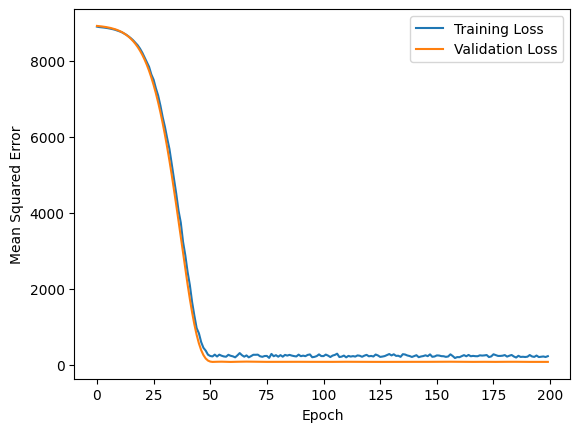

In [52]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(df[numerical_features + categorical_features], df[target], test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Shapes after splitting:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

# Standardize the numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Preprocess categorical features
label_encoders = {}
for cat_feature in categorical_features:
    le = LabelEncoder()
    X_train[cat_feature] = le.fit_transform(X_train[cat_feature])
    X_val[cat_feature] = le.transform(X_val[cat_feature])
    X_test[cat_feature] = le.transform(X_test[cat_feature])
    label_encoders[cat_feature] = le

# Define the learning rate
learning_rate = 0.0001  

# Define the model
input_layers = []
embedding_layers = []

for cat_feature in categorical_features:
    input_layer = Input(shape=(1,), name=cat_feature)
    embedding_layer = Embedding(input_dim=len(df[cat_feature].unique()), output_dim=10)(input_layer)
    flatten_layer = Flatten()(embedding_layer)
    input_layers.append(input_layer)
    embedding_layers.append(flatten_layer)

numerical_input = Input(shape=(len(numerical_features),), name='numerical_input')
embedding_layers.append(numerical_input)

# Concatenate all input layers
concatenated = Concatenate()(embedding_layers)

# Fully connected layers with dropout for regularization
x = Dense(256, activation='relu')(concatenated)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(1, activation='linear', name='output')(x)

# Model
model = Model(inputs=input_layers + [numerical_input], outputs=output_layer)

# Compile the model with Mean Squared Error loss and the specified learning rate
model.compile(optimizer=Adam(lr=learning_rate), loss='mean_squared_error')

# Train the model for more epochs
history = model.fit([X_train[cat_feature] for cat_feature in categorical_features] + [X_train[numerical_features]],
                    y_train, epochs=200, batch_size=64,
                    validation_data=([X_val[cat_feature] for cat_feature in categorical_features] + [X_val[numerical_features]], y_val),
                    verbose=1)

# Evaluate the model on the test set
test_loss = model.evaluate([X_test[cat_feature] for cat_feature in categorical_features] + [X_test[numerical_features]], y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
predictions = model.predict([X_test[cat_feature] for cat_feature in categorical_features] + [X_test[numerical_features]])

# You can use predictions for further analysis or visualization

# Plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()